### Import the relevant packages 

In [32]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split

### Reading the tumor MRI images 

In [33]:
tumor = []
path_to_tumor_images = glob.iglob('./data/brain_tumor_dataset/yes/*.jpg')

for file in path_to_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (128, 128))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    tumor.append(img)


print(f'Number of tumor images: {len(tumor)}')

Number of tumor images: 783


### Reading the healthy MRI images

In [34]:
no_tumor = []
path_to_no_tumor_images = glob.iglob('./data/brain_tumor_dataset/no/*.jpg')

for file in path_to_no_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (128, 128))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    no_tumor.append(img)


print(f'Number of healthy images: {len(no_tumor)}')

Number of healthy images: 796


### Converting the lists of images to numpy arrays

In [35]:
tumor = np.array(tumor)
no_tumor = np.array(no_tumor)

### Taking a look at the dimensions of the arrays

In [36]:
print(f"Shape of tumor images array: {tumor.shape}")
print(f"Number of images: {tumor.shape[0]}")
print(f"Number of channels: {tumor.shape[3]} (RGB)")
print(f"Size of each channel: {tumor.shape[1]} x {tumor.shape[2]}")

print("\n")

print(f"Shape of no tumor images array: {no_tumor.shape}")
print(f"Number of images: {no_tumor.shape[0]}")
print(f"Number of channels: {no_tumor.shape[3]} (RGB)")
print(f"Size of each channel: {no_tumor.shape[1]} x {no_tumor.shape[2]}")

Shape of tumor images array: (783, 128, 128, 3)
Number of images: 783
Number of channels: 3 (RGB)
Size of each channel: 128 x 128


Shape of no tumor images array: (796, 128, 128, 3)
Number of images: 796
Number of channels: 3 (RGB)
Size of each channel: 128 x 128


### Visualizing some of the MRI images 

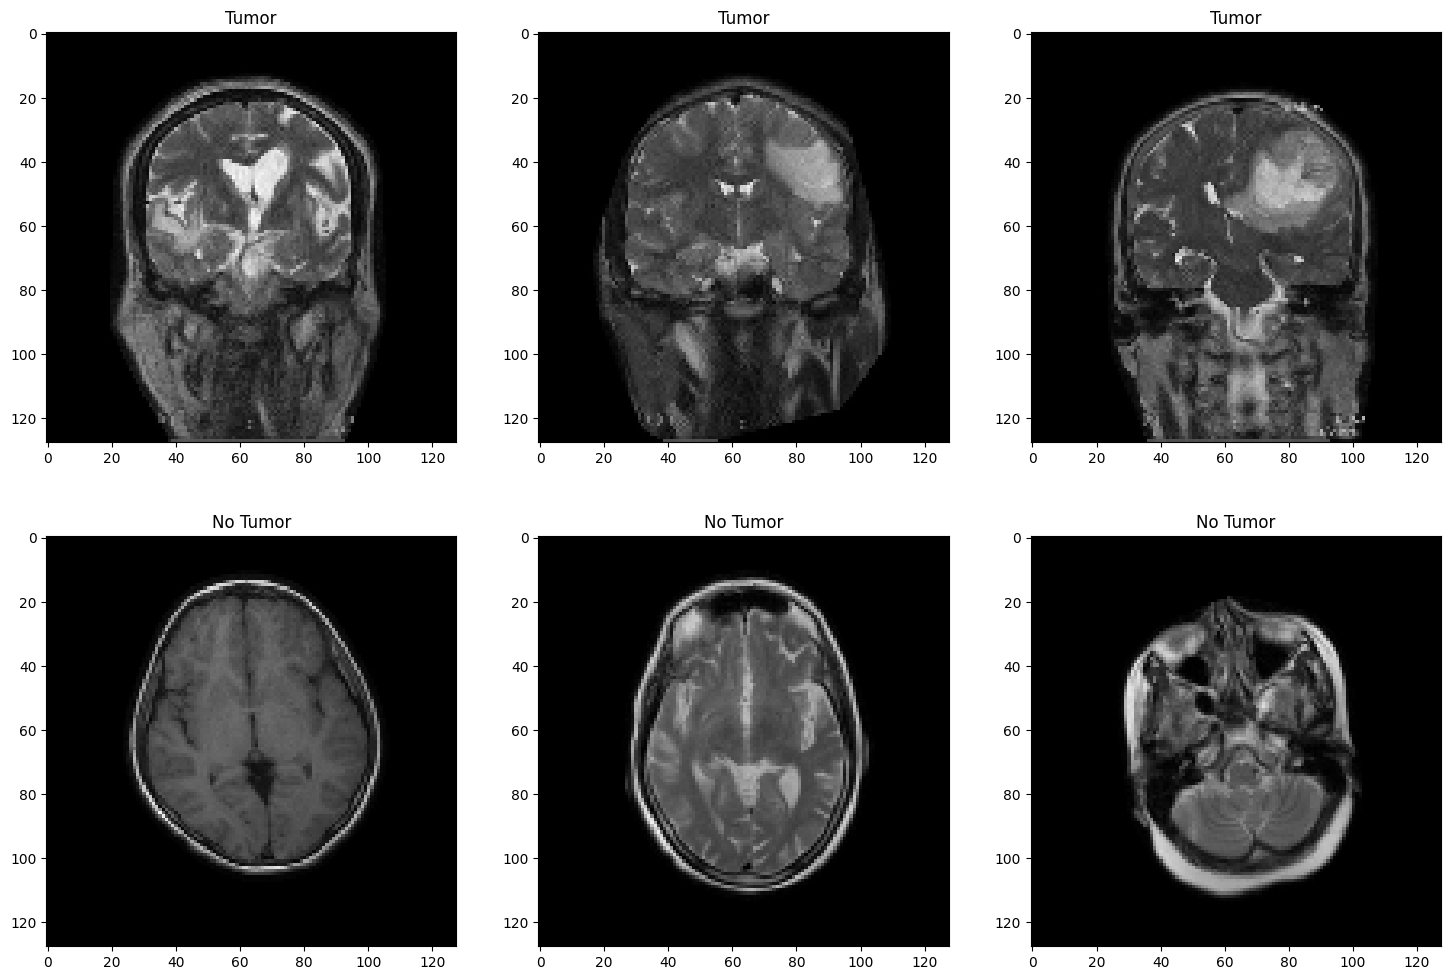

In [37]:
# initialize the plot
plt.figure(figsize=(18, 12))

for i in range(3):
    # tumor images
    plt.subplot(2, 3, i+1)
    plt.title('Tumor')
    plt.imshow(tumor[random.randint(0, len(tumor)-1)])

    # no_tumor images
    plt.subplot(2, 3, i+4)
    plt.title('No Tumor')
    plt.imshow(no_tumor[random.randint(0, len(no_tumor)-1)])

### Creating a custom pytorch Dataset class

In [38]:
class MRI(Dataset):

    def __init__(self, images, labels):
        """Initializes the object and splits data into train/val/test sets."""
        # Reorder images array for PyTorch convention
        images = images.reshape((images.shape[0], images.shape[3], images.shape[1], images.shape[2]))

        # Split data into training and testing sets (80/20 split)
        self.images, self.images_test, self.labels, self.labels_test = train_test_split(
            images.astype(np.float32), labels, test_size=0.2, random_state=42
        )

        # Further split the training set into train and validation sets (60/20/20 split)
        self.images_train, self.images_val, self.labels_train, self.labels_val = train_test_split(
            self.images, self.labels, test_size=0.25, random_state=42
        )

        # Set default mode to "train"
        self.mode = "train"


    def __len__(self):
        """Returns the amount of images in the dataset (considering the current mode). """
        # Adjust the logic based on the current mode (train, val, or test)
        if self.mode == "train":
            return len(self.images_train)
        elif self.mode == "val":
            return len(self.images_val)
        elif self.mode == "test":
            return len(self.images_test)


    def __getitem__(self, index):
        """Returns a custom representation of the data inside the object (considering the current mode). """
        # Access data based on the current mode
        if self.mode == "train":
            image = self.images_train[index]
            label = self.labels_train[index]
        elif self.mode == "val":
            image = self.images_val[index]
            label = self.labels_val[index]
        elif self.mode == "test":
            image = self.images_test[index]
            label = self.labels_test[index]

        # Convert data to float32 and return as a dictionary
        item = {"image": image.astype(np.float32), "label": label.astype(np.float32)}
        return item


    def normalize(self):
        """Normalizes the images(optional). """
        self.images_train /= 255.0
        self.images_val /= 255.0
        self.images_test /= 255.0


    def set_mode(self, mode):
        """Sets the current mode (train, val, or test). """
        if mode not in ["train", "val", "test"]:
            raise ValueError(f"Invalid mode: {mode}")
        self.mode = mode


### Getting the data ready for the custom dataset

In [39]:
# create arrays for the labels. tumors are represented by ones, no tumors are represented by zeros
tumor_labels = np.ones(tumor.shape[0])
no_tumor_labels = np.zeros(no_tumor.shape[0])

# combine the images into one array for the dataset
combined_images = np.concatenate((tumor, no_tumor), axis=0)

# combine the labels into one array for the dataset
combined_labels = np.concatenate((tumor_labels, no_tumor_labels))

### Putting the arrays of MRI images into the custom dataset

In [40]:
# create an MRI object from the custom dataclass by giving it the images and labels
mri_dataset = MRI(images=combined_images, labels=combined_labels)

# execute the normalize function of the MRI class
mri_dataset.normalize()

### Defining a neural network class

In [41]:
class CNN(nn.Module):

    def __init__(self):

        # initialize the super class
        super(CNN, self).__init__()

        # define the neural network structure
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        # define the fully connected (fc) model structure
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1),
        )

    # define the forward propagation
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

### Switching the device used by pytorch to the GPU of the system

In [42]:
# check if the systems graphics processing unit allows for CUDA
torch.cuda.is_available()

# get the GPU as the device for pytorch
device = torch.device('cuda:0')

# tell the model to run on the GPU
model = CNN().to(device)

### Setting hyperparameters for the model training

In [43]:
# set the learning rate
eta = 0.0001

# set the epochs / amount of passes through the entire dataset
EPOCH = 250

# choose the popular Adam algorithm as the optimization technique
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

# use the DataLoader from pytorch to grab batches of 32 random images
mri_dataset.set_mode("train")
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)

# set the model to training mode
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

### Training the model

In [44]:
# initialize the separate dataloaders
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

# keep track of epoch losses in order to visualize them later and make adjustments to the hyperparameters (if needed)
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(1, EPOCH):

    # initialize the training losses list
    train_losses = []

    # switch the datasets mode to train
    mri_dataset.set_mode('train')

    # for each batch of 32 images and labels
    for D in train_dataloader:

        # reset gradients to zero before processing the current batch
        optimizer.zero_grad()

        # extract the images and labels and move them over to the device (GPU)
        data = D['image'].to(device)
        label = D['label'].to(device)

        # pass the data through the model to get the predictions
        y_hat = model(data)

        # define Binary Cross Entropy Loss as the loss function
        error = nn.BCELoss()

        # calculate the total loss for the batch by summing the individual losses per image
        loss = torch.sum(error(y_hat.squeeze(), label))

        # perform backpropagation to calculate gradients based on the current batch loss
        loss.backward()

        # update the model parameters using the calculated gradients and the optimizer algorithm
        optimizer.step()

        # append the current batch loss to the training losses list
        train_losses.append(loss.item())

    # append the mean of the training losses to the epoch training losses list
    epoch_train_loss.append(np.mean(train_losses))

    # initialize the validation losses list
    val_losses = []

    # switch the model to evaluation mode
    model.eval()

    # switch the datasets mode to validation
    mri_dataset.set_mode('val')

    # deactivate gradient calculation (with torch.no_grad()) as we don't update parameters during validation
    with torch.no_grad():

        # for each batch of 32 images and labels
        for D in val_dataloader:

            # extract the images and labels and move them over to the device (GPU)
            data = D['image'].to(device)
            label = D['label'].to(device)

            # pass the data through the model to get the predictions
            y_hat = model(data)

            # define Binary Cross Entropy Loss as the loss function
            error = nn.BCELoss()

            # calculate the total loss for the batch by summing the individual losses per image
            loss = torch.sum(error(y_hat.squeeze(), label))

            # append the current batch loss to the validation losses list
            val_losses.append(loss.item())

    # append the mean of the validation losses to the epoch validation losses list
    epoch_val_loss.append(np.mean(val_losses))

    # print the training epoch number and average losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(
            epoch + 1, np.mean(train_losses), np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.526957	Val Loss: 0.490038
Train Epoch: 20	Train Loss: 0.473922	Val Loss: 0.449096
Train Epoch: 30	Train Loss: 0.429044	Val Loss: 0.400981
Train Epoch: 40	Train Loss: 0.371990	Val Loss: 0.352256
Train Epoch: 50	Train Loss: 0.311975	Val Loss: 0.310854
Train Epoch: 60	Train Loss: 0.246480	Val Loss: 0.299188
Train Epoch: 70	Train Loss: 0.227735	Val Loss: 0.297581
Train Epoch: 80	Train Loss: 0.183028	Val Loss: 0.279950
Train Epoch: 90	Train Loss: 0.151456	Val Loss: 0.277485
Train Epoch: 100	Train Loss: 0.128597	Val Loss: 0.281696
Train Epoch: 110	Train Loss: 0.106797	Val Loss: 0.269981
Train Epoch: 120	Train Loss: 0.107579	Val Loss: 0.303361
Train Epoch: 130	Train Loss: 0.074067	Val Loss: 0.266306
Train Epoch: 140	Train Loss: 0.059303	Val Loss: 0.270691
Train Epoch: 150	Train Loss: 0.051817	Val Loss: 0.287479
Train Epoch: 160	Train Loss: 0.039426	Val Loss: 0.283673
Train Epoch: 170	Train Loss: 0.031262	Val Loss: 0.294151
Train Epoch: 180	Train Loss: 0.022447	Va

### Evaluating the model

In [45]:
# switch the model from training mode to evaluation mode
model.eval()

# switch the datasets mode to test in order to evaluate the model on previously unseen data
mri_dataset.set_mode('test')
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

outputs = []
y_true = []

# disable gradient calculation temporarily
with torch.no_grad():

    for D in dataloader:
        # extract the images and labels and move them over to the device (GPU)
        image = D['image'].to(device)
        label = D['label'].to(device)

        # pass the data through the model to get the predictions
        y_hat = model(image)

        # store the predictions and true labels for later analysis
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

# concatenate the collected predictions and true labels from all batches into single NumPy array
outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

### Defining a binary threshold 

In [46]:
def binary_threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    """This function takes a list of scores and applies a binary threshold to them."""

    # Convert input to a NumPy array for efficient processing
    x = np.array(list(scores))

    # Scores above/equal threshold set to maximum
    x[x >= threshold] = maximum

    # Scores below threshold set to minimum
    x[x < threshold] = minimum

    return x

## Testing the accuracy of the model on the data it was trained on

In [47]:
accuracy_score(y_true, binary_threshold(outputs))

0.9272151898734177

### Plotting a confusion matrix for the model evaluation

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

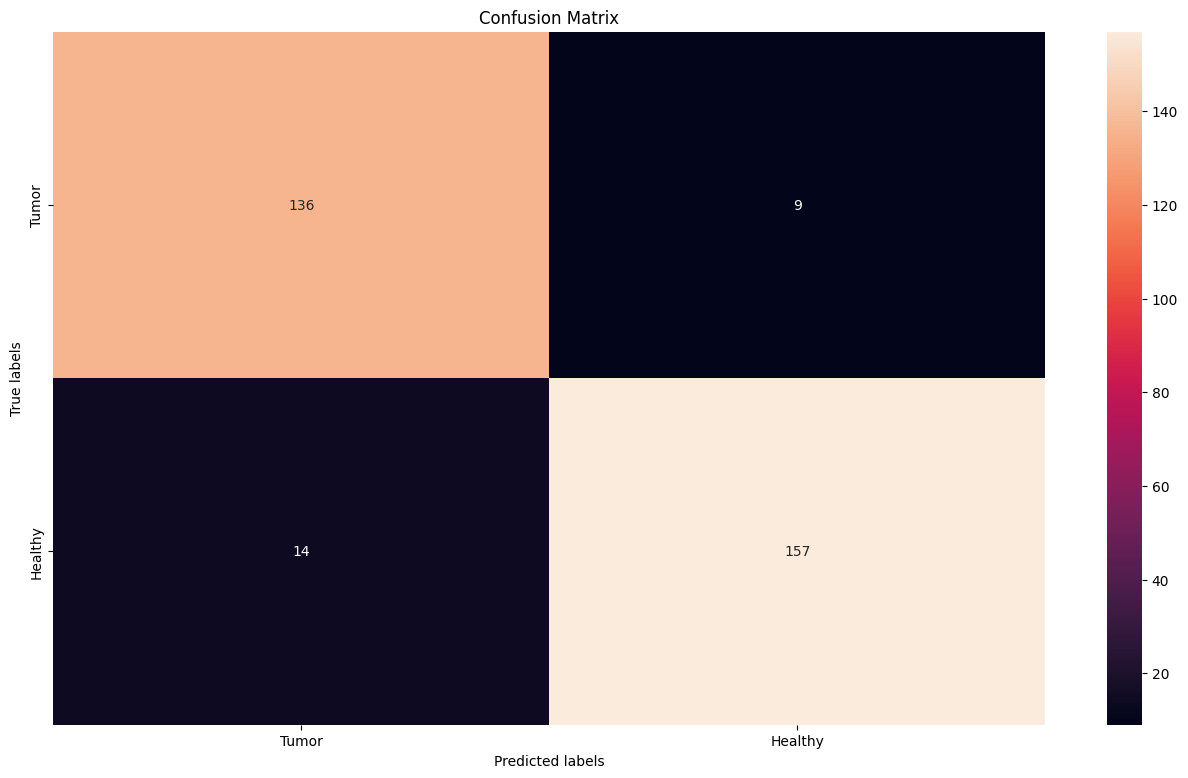

In [48]:
# create the confusion matrix
cm = confusion_matrix(y_true, binary_threshold(outputs))

# define the size of the matplotlib plot
plt.figure(figsize=(16,9))

# create a heatmap
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# customize the labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# set tick labels for readability
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

### Visualizing the training and validation loss 


Text(0, 0.5, 'Loss')

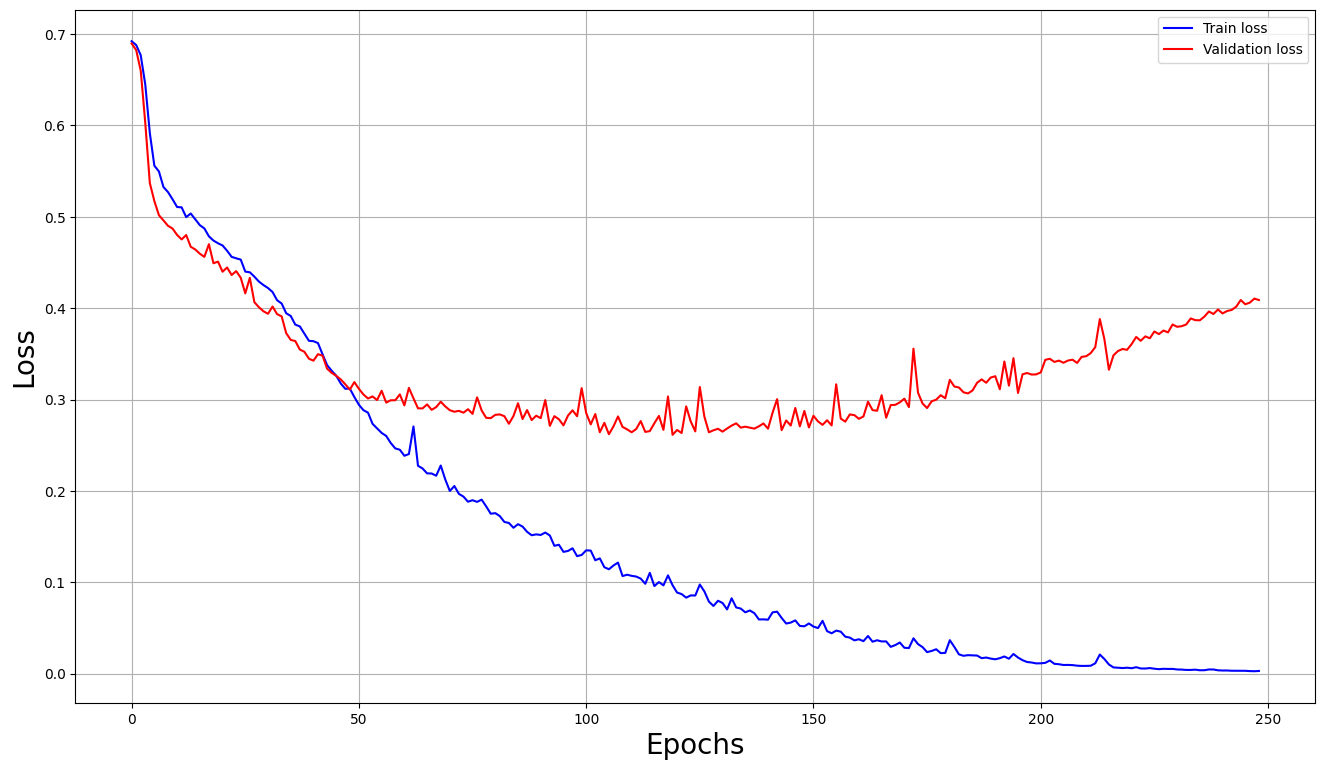

In [49]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)